## Store Sales - Time Series Forecasting

In [1]:
#impport Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read available data sets
train = pd.read_csv(r"store-sales-forecasting/train.csv")
test = pd.read_csv(r"store-sales-forecasting/test.csv")
stores = pd.read_csv(r"store-sales-forecasting/stores.csv")
transactions = pd.read_csv(r"store-sales-forecasting/transactions.csv")
holidays = pd.read_csv(r"store-sales-forecasting/holidays_events.csv")


In [3]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [4]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## EDA

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
# data information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
train.shape

(3000888, 6)

In [8]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [10]:
test.shape

(28512, 5)

In [11]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [13]:
print(stores.shape)

(54, 5)


In [14]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [15]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [16]:
unique_values = train['family'].unique()
print(unique_values)

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [17]:
unique_values = test['family'].unique()
print(unique_values)

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [18]:
train['family'] = train['family'].replace({'GROCERY I': 'GROCERY', 'GROCERY II': 'GROCERY'})
train['family'] = train['family'].replace({'HOME AND KITCHEN I': 'HOME AND KITCHEN', 'HOME AND KITCHEN II': 'HOME AND KITCHEN'})
train['family'] = train['family'].replace('LINGERIE', 'LADIESWEAR')

train['family'] = train['family'].replace({'BREAD/BAKERY': 'FOOD ITEMS', 'BEVERAGES': 'FOOD ITEMS', 'DAIRY': 'FOOD ITEMS', 'DELI': 'FOOD ITEMS', 'EGGS': 'FOOD ITEMS', 'FROZEN FOODS': 'FOOD ITEMS','MEATS': 'FOOD ITEMS','POULTRY': 'FOOD ITEMS','PREPARED FOODS': 'FOOD ITEMS', 'PRODUCE': 'FOOD ITEMS', 'SEAFOOD': 'FOOD ITEMS' })
train['family'] = train['family'].replace({'BOOKS':'BOOKS/MAGAZINES','MAGAZINES':'BOOKS/MAGAZINES'} )
train['family'] = train['family'].replace('BEAUTY', 'PERSONAL CARE')


train['family'] = train['family'].replace('BEAUTY', 'PERSONAL CARE')
train['family'] = train['family'].replace('BEAUTY', 'PERSONAL CARE')
train['family'] = train['family'].replace('BEAUTY', 'PERSONAL CARE')


train['family'] = train['family'].replace({'LIQUOR,WINE,BEER': 'ALCOHOLIC BEVERAGES' })
train['family'] = train['family'].replace({'FOOD ITEMS': 'FOOD & GROCERY', 'GROCERY': 'FOOD & GROCERY'})
train['family'] = train['family'].replace({'HOME AND KITCHEN': 'HOME PRODUCTS', 'HOME APPLIANCES': 'HOME PRODUCTS', 'HOME CARE':'HOME PRODUCTS', 'LAWN AND GARDEN':'HOME PRODUCTS', 'AUTOMOTIVE':'HOME PRODUCTS', 'HARDWARE':'HOME PRODUCTS'})
train['family'] = train['family'].replace({'BABY CARE': 'PERSONAL & BEAUTY', 'PERSONAL CARE': 'PERSONAL & BEAUTY', 'LADIESWEAR':'PERSONAL & BEAUTY'})


In [19]:
test['family'] = test['family'].replace({'GROCERY I': 'GROCERY', 'GROCERY II': 'GROCERY'})
test['family'] = test['family'].replace({'HOME AND KITCHEN I': 'HOME AND KITCHEN', 'HOME AND KITCHEN II': 'HOME AND KITCHEN'})
test['family'] = test['family'].replace('LINGERIE', 'LADIESWEAR')

test['family'] = test['family'].replace({'BREAD/BAKERY': 'FOOD ITEMS', 'BEVERAGES': 'FOOD ITEMS', 'DAIRY': 'FOOD ITEMS', 'DELI': 'FOOD ITEMS', 'EGGS': 'FOOD ITEMS', 'FROZEN FOODS': 'FOOD ITEMS','MEATS': 'FOOD ITEMS','POULTRY': 'FOOD ITEMS','PREPARED FOODS': 'FOOD ITEMS', 'PRODUCE': 'FOOD ITEMS', 'SEAFOOD': 'FOOD ITEMS' })
test['family'] = test['family'].replace({'BOOKS':'BOOKS/MAGAZINES','MAGAZINES':'BOOKS/MAGAZINES'} )
test['family'] = test['family'].replace('BEAUTY', 'PERSONAL CARE')


test['family'] = test['family'].replace('BEAUTY', 'PERSONAL CARE')
test['family'] = test['family'].replace('BEAUTY', 'PERSONAL CARE')
test['family'] = test['family'].replace('BEAUTY', 'PERSONAL CARE')


test['family'] = test['family'].replace({'LIQUOR,WINE,BEER': 'ALCOHOLIC BEVERAGES' })
test['family'] = test['family'].replace({'FOOD ITEMS': 'FOOD & GROCERY', 'GROCERY': 'FOOD & GROCERY'})
test['family'] = test['family'].replace({'HOME AND KITCHEN': 'HOME PRODUCTS', 'HOME APPLIANCES': 'HOME PRODUCTS', 'HOME CARE':'HOME PRODUCTS', 'LAWN AND GARDEN':'HOME PRODUCTS', 'AUTOMOTIVE':'HOME PRODUCTS', 'HARDWARE':'HOME PRODUCTS'})
test['family'] = test['family'].replace({'BABY CARE': 'PERSONAL & BEAUTY', 'PERSONAL CARE': 'PERSONAL & BEAUTY', 'LADIESWEAR':'PERSONAL & BEAUTY'})


In [20]:
unique_values = train['family'].unique()
print(unique_values)

['HOME PRODUCTS' 'PERSONAL & BEAUTY' 'FOOD & GROCERY' 'BOOKS/MAGAZINES'
 'CELEBRATION' 'CLEANING' 'ALCOHOLIC BEVERAGES' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'SCHOOL AND OFFICE SUPPLIES']


In [21]:
unique_values = test['family'].unique()
print(unique_values)

['HOME PRODUCTS' 'PERSONAL & BEAUTY' 'FOOD & GROCERY' 'BOOKS/MAGAZINES'
 'CELEBRATION' 'CLEANING' 'ALCOHOLIC BEVERAGES' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'SCHOOL AND OFFICE SUPPLIES']


In [22]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,HOME PRODUCTS,0.0,0
1,1,2013-01-01,1,PERSONAL & BEAUTY,0.0,0
2,2,2013-01-01,1,PERSONAL & BEAUTY,0.0,0
3,3,2013-01-01,1,FOOD & GROCERY,0.0,0
4,4,2013-01-01,1,BOOKS/MAGAZINES,0.0,0


In [23]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Data visualization and processing

<AxesSubplot:xlabel='store_nbr', ylabel='sales'>

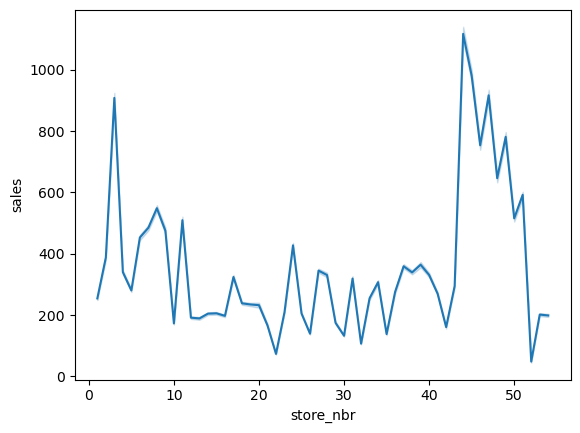

In [24]:
sns.lineplot(x="store_nbr", y="sales",
             data=train)

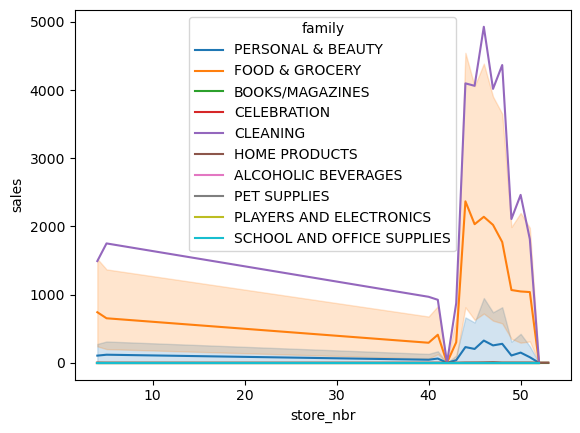

In [25]:
# Plot the responses for different events and regions
sns.lineplot(x="store_nbr", y="sales",
             hue="family",
             data=train[10000:10500])
plt.show()

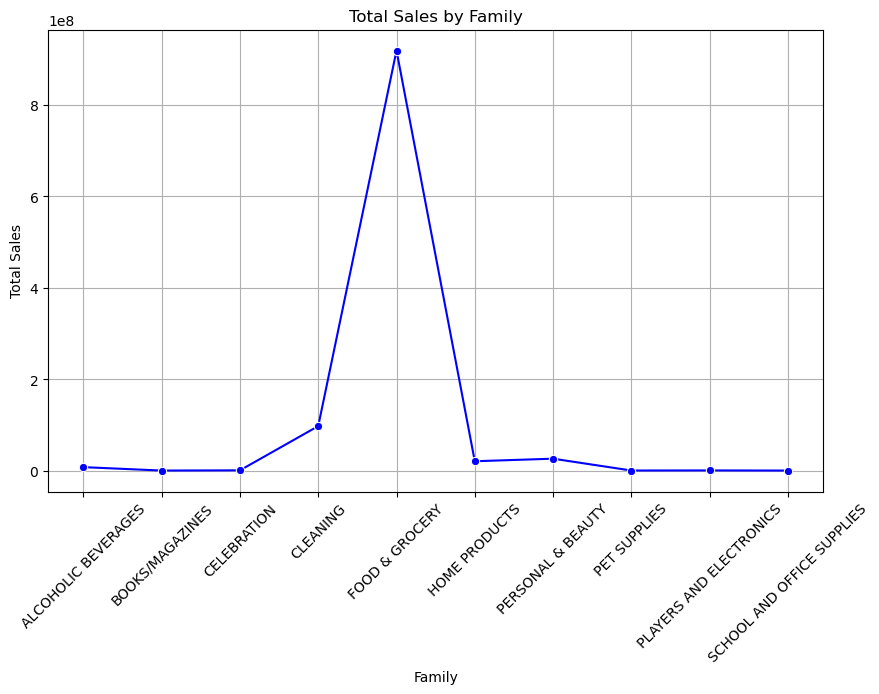

In [26]:
# Calculate total sales for each family across all stores
total_sales_by_family = train.groupby('family')['sales'].sum().reset_index()

# Plotting a line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x="family", y="sales", data=total_sales_by_family, marker='o', color='blue')
plt.xlabel('Family')
plt.ylabel('Total Sales')
plt.title('Total Sales by Family')
plt.xticks(rotation=45)
plt.grid(True)  # Add grid lines for better readability
plt.show()


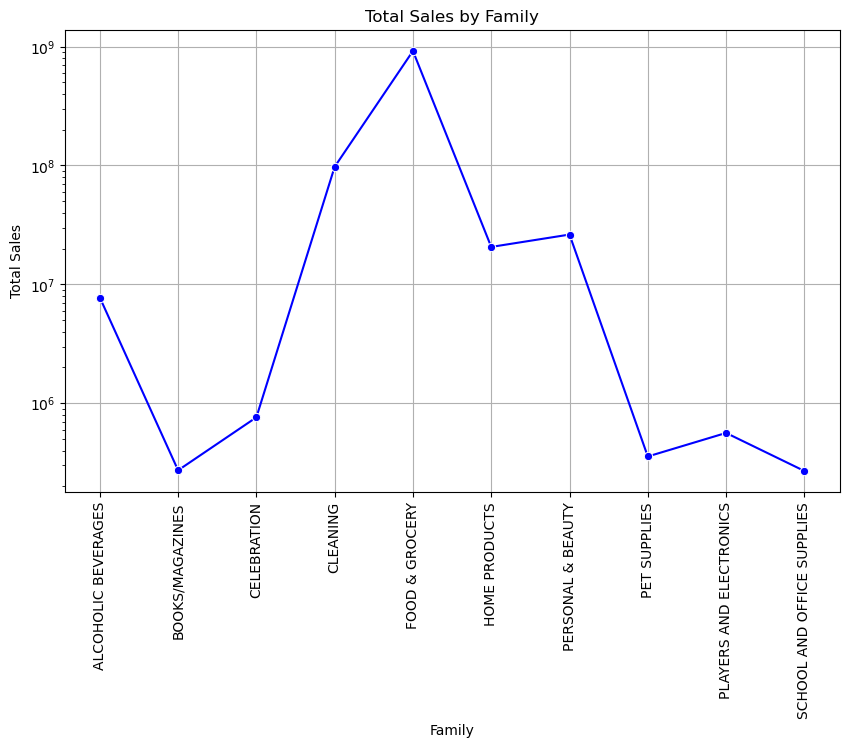

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total sales for each family across all stores
total_sales_by_family = train.groupby('family')['sales'].sum().reset_index()

# Plotting a line chart with logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
sns.lineplot(x="family", y="sales", data=total_sales_by_family, marker='o', color='blue')
plt.xlabel('Family')
plt.ylabel('Total Sales')
plt.title('Total Sales by Family')
plt.xticks(rotation=90)
plt.yscale('log')  # Set logarithmic scale on the y-axis
plt.grid(True)  # Add grid lines for better readability

plt.show()


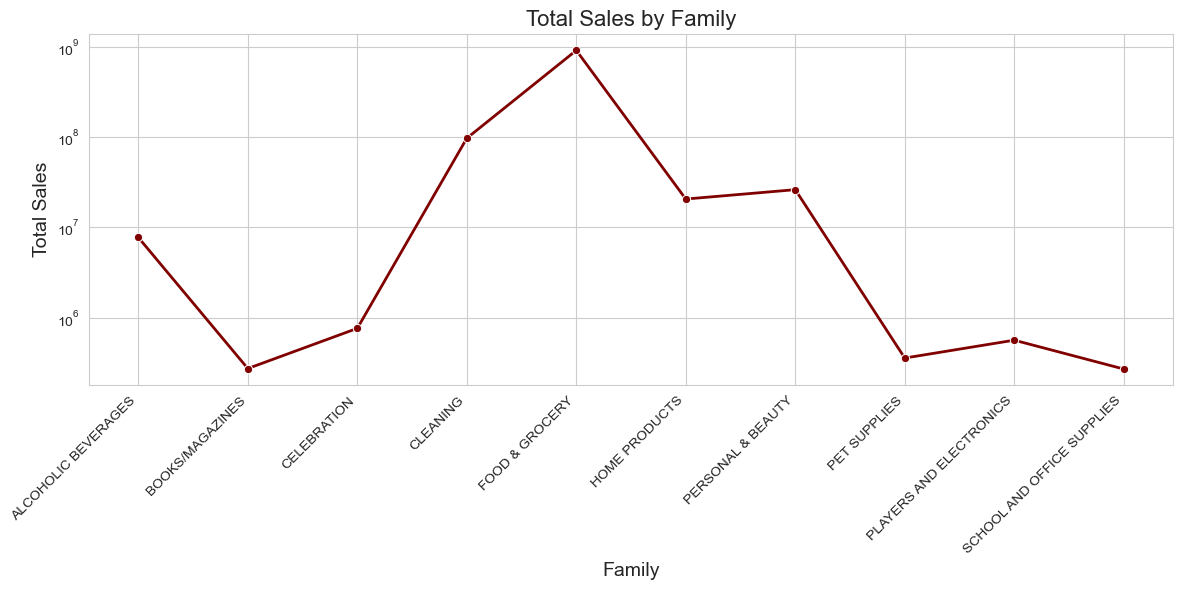

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total sales for each family across all stores
total_sales_by_family = train.groupby('family')['sales'].sum().reset_index()

# Set style
sns.set_style("whitegrid")

# Plotting a line chart with logarithmic scale on the y-axis
plt.figure(figsize=(12, 6))
sns.lineplot(x="family", y="sales", data=total_sales_by_family, marker='o', color='maroon', linewidth=2)
plt.xlabel('Family', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.title('Total Sales by Family', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('log')  # Set logarithmic scale on the y-axis
#plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


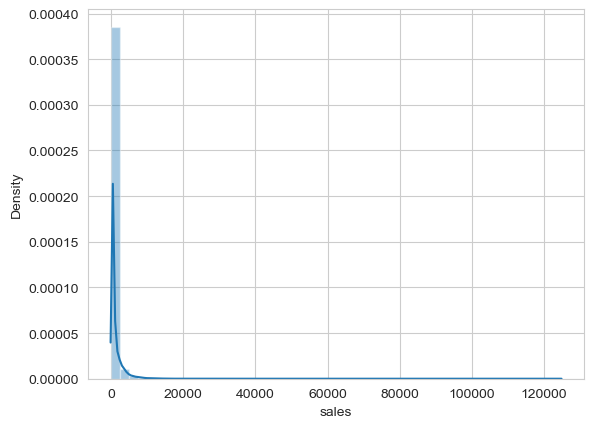

In [29]:
sns.distplot(train['sales'])
plt.show()

In [30]:
df=pd.concat([train,test])
df.drop(columns='id',inplace=True)

print("Shape of df:", df.shape)

Shape of df: (3029400, 5)


In [31]:
df['date'] = pd.to_datetime(df['date'])
categorical_cols = ['store_nbr', 'family']

for col in categorical_cols:
    print(f"Unique values in {col}: {df[col].nunique()}")


Unique values in store_nbr: 54
Unique values in family: 10


In [32]:
# Feature Engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int) 

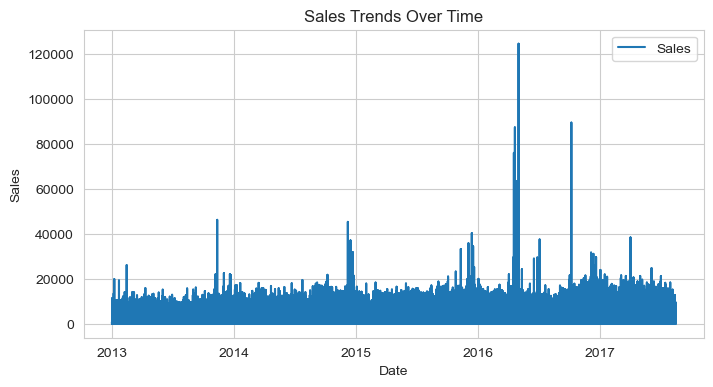

In [33]:
# Data Visualization on sales
plt.figure(figsize=(8, 4))
plt.plot(df['date'], df['sales'], label='Sales')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

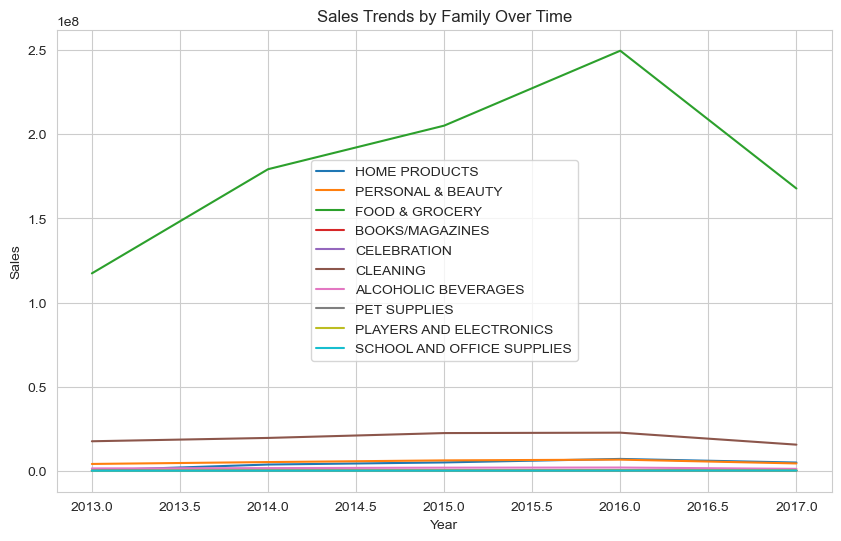

In [34]:

# Extract year from the date column
df['year'] = df['date'].dt.year

# Group by year and family to calculate total sales
sales_by_year_and_family = df.groupby(['year', 'family'])['sales'].sum().reset_index()

# Plotting sales trends for each family over the years
plt.figure(figsize=(10, 6))

# Iterate over unique families and plot sales
for family in df['family'].unique():
    family_sales = sales_by_year_and_family[sales_by_year_and_family['family'] == family]
    plt.plot(family_sales['year'], family_sales['sales'], label=family)

plt.title('Sales Trends by Family Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


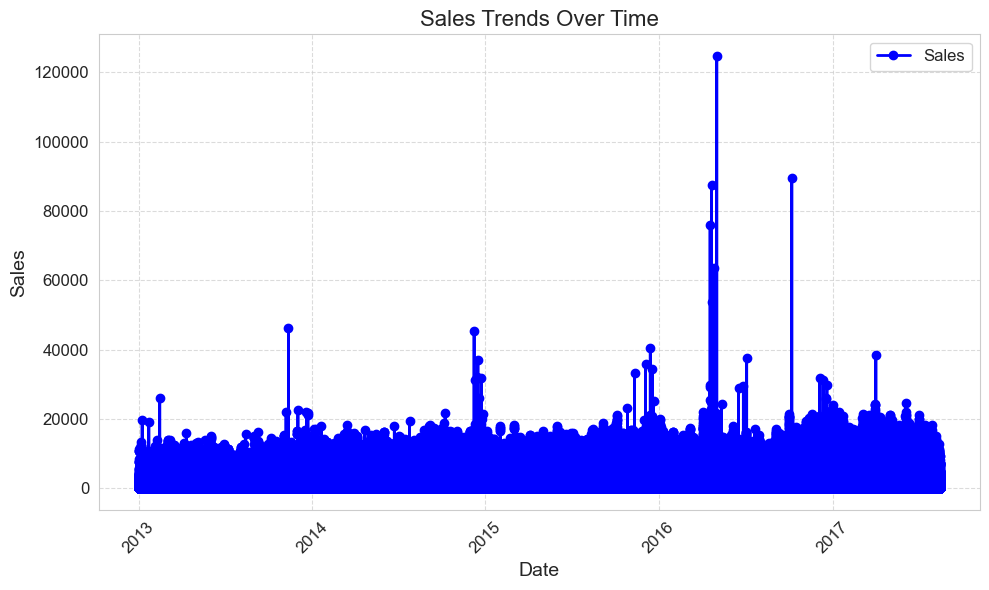

In [35]:
import matplotlib.pyplot as plt

# Convert 'date' column to datetime if it's not already in datetime format
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(10, 6))

# Plotting sales trends over time
plt.plot(df['date'], df['sales'], color='blue', linewidth=2, marker='o', markersize=6, label='Sales')

# Title and labels
plt.title('Sales Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick labels
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Adding a legend
plt.legend(fontsize=12)

# Adding annotations
plt.text(df['date'].iloc[-1], df['sales'].iloc[-1], f'{df["sales"].iloc[-1]}', fontsize=12, verticalalignment='bottom')

plt.tight_layout()
plt.show()


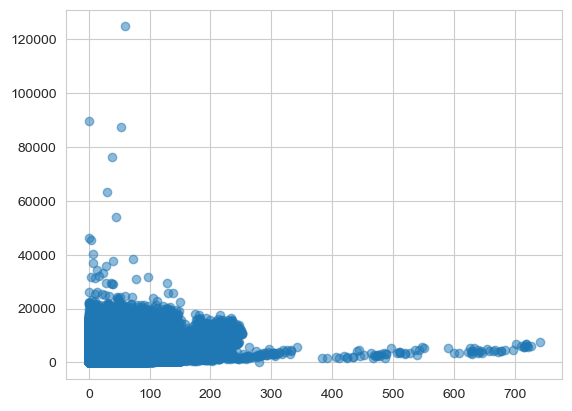

In [36]:
plt.scatter(df['onpromotion'],df['sales'],alpha=0.5)
plt.show()

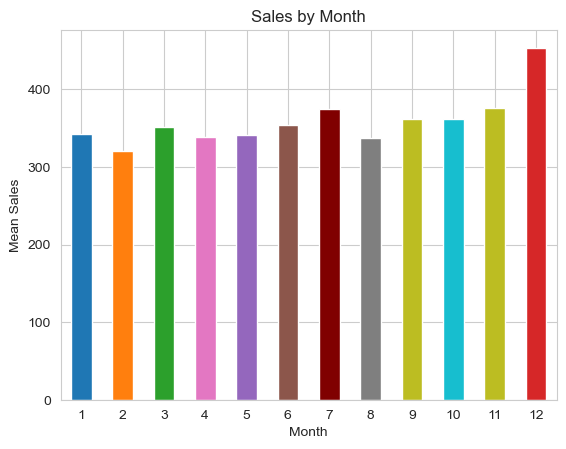

In [37]:
# Assuming 'df' is your DataFrame and you want to group by 'month' and calculate mean sales
p = df.groupby('month')['sales'].mean()

# Plotting the results
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#9467bd', '#8c564b', '#800000', '#7f7f7f','#bcbd22', '#17becf', '#bcbd22', '#d62728']

p.plot(kind='bar', color=colors)
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Mean Sales')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


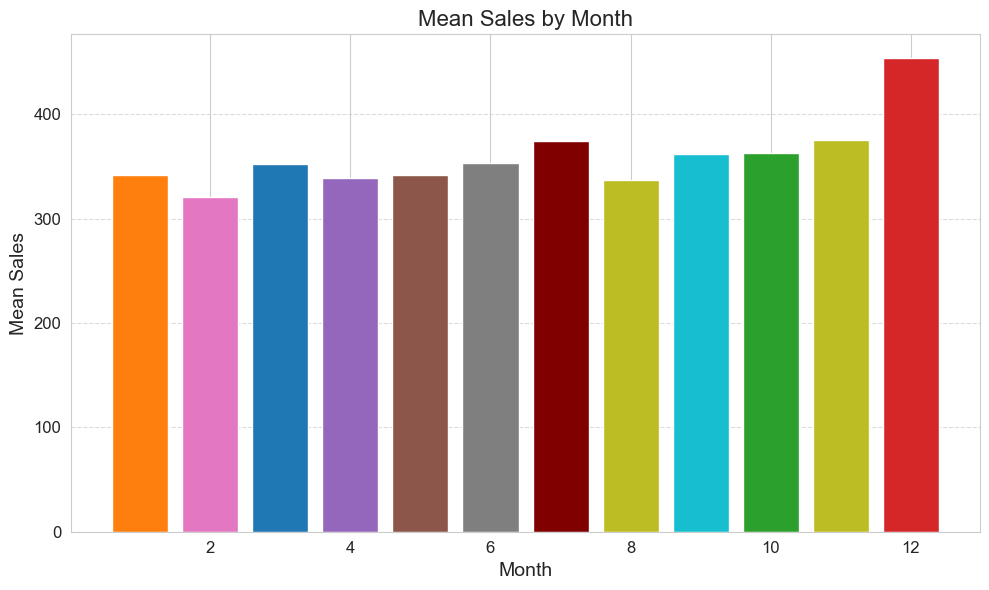

In [38]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and you want to group by 'month' and calculate mean sales
p = df.groupby('month')['sales'].mean()

# Define your custom colors
colors = ['#ff7f0e',  '#e377c2','#1f77b3', '#9467bd', '#8c564b', '#7f7f7f','#800000','#bcbd22', '#17becf','#2ca02c', '#bcbd22', '#d62728']

# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the bar chart with custom colors
plt.bar(p.index, p.values, color=colors)

plt.title('Mean Sales by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Mean Sales', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [39]:
train_merged = df

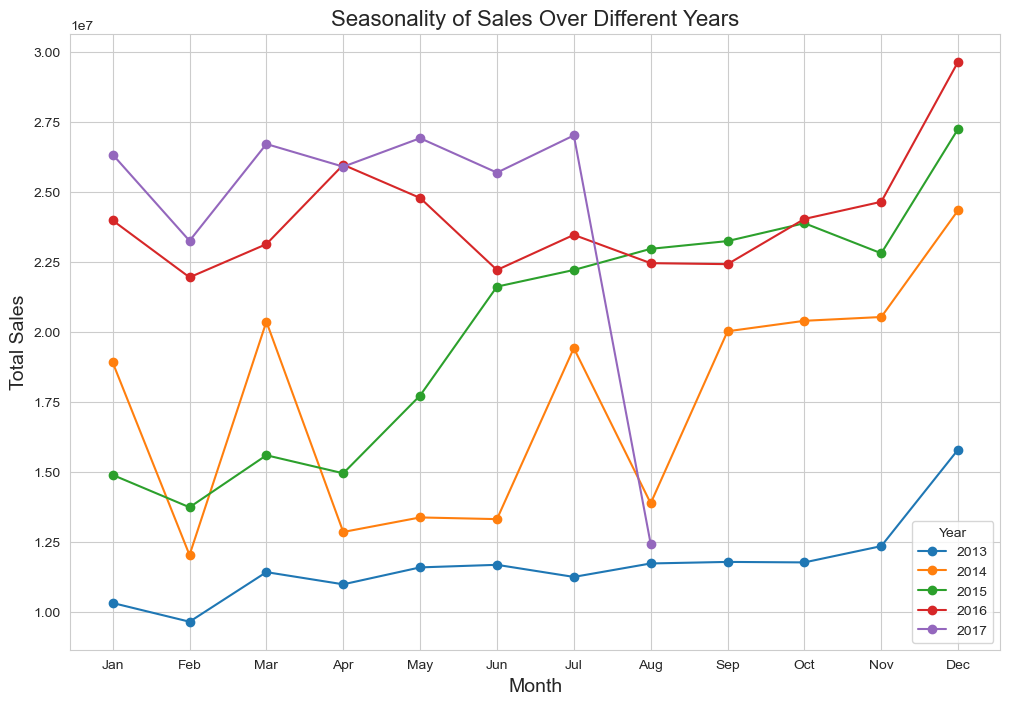

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

# Assuming 'train_merged' DataFrame already exists with required columns

# Ensure 'date' is in datetime format
train_merged['date'] = pd.to_datetime(train_merged['date'])

# Extract year and month from 'date'
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month

# Aggregate sales by year and month
monthly_sales = train_merged.groupby(['year', 'month'])['sales'].sum().reset_index()

# Pivot the data for easy plotting
monthly_sales_pivot = monthly_sales.pivot(index="month", columns="year", values="sales")

# Create the line plot directly from monthly_sales without pivoting
plt.figure(figsize=(12, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i, year in enumerate(monthly_sales['year'].unique()):
    year_data = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_data['month'], year_data['sales'], marker='o', label=str(year), color=colors[i])

# Adjusting x-axis to show month names
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Enhancing the plot
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.title('Seasonality of Sales Over Different Years', fontsize=16)
plt.legend(title='Year')

# Show the plot
plt.grid(True)
plt.show()


In [41]:
train_merged.head()

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,weekend
0,2013-01-01,1,HOME PRODUCTS,0.0,0,2013,1,1,1,0
1,2013-01-01,1,PERSONAL & BEAUTY,0.0,0,2013,1,1,1,0
2,2013-01-01,1,PERSONAL & BEAUTY,0.0,0,2013,1,1,1,0
3,2013-01-01,1,FOOD & GROCERY,0.0,0,2013,1,1,1,0
4,2013-01-01,1,BOOKS/MAGAZINES,0.0,0,2013,1,1,1,0


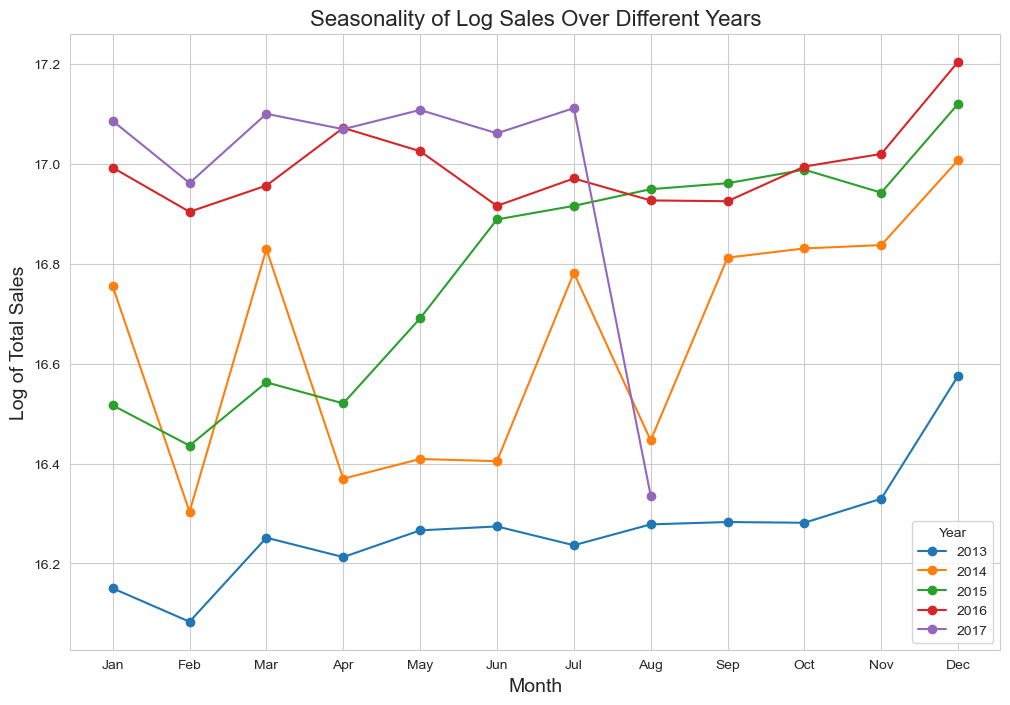

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

# Assuming 'train_merged' DataFrame already exists with required columns

# Ensure 'date' is in datetime format
train_merged['date'] = pd.to_datetime(train_merged['date'])

# Extract year and month from 'date'
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month

# Aggregate sales by year and month
monthly_sales = train_merged.groupby(['year', 'month'])['sales'].sum().reset_index()

# Pivot the data for easy plotting
monthly_sales_pivot = monthly_sales.pivot(index="month", columns="year", values="sales")

# Take the logarithm of sales
monthly_sales['sales'] = np.log(monthly_sales['sales'])

# Create the line plot directly from monthly_sales without pivoting
plt.figure(figsize=(12, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i, year in enumerate(monthly_sales['year'].unique()):
    year_data = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_data['month'], year_data['sales'], marker='o', label=str(year), color=colors[i])

# Adjusting x-axis to show month names
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Enhancing the plot
plt.xlabel('Month', fontsize=14)
plt.ylabel('Log of Total Sales', fontsize=14)
plt.title('Seasonality of Log Sales Over Different Years', fontsize=16)
plt.legend(title='Year')

# Show the plot
plt.grid(True)
plt.show()


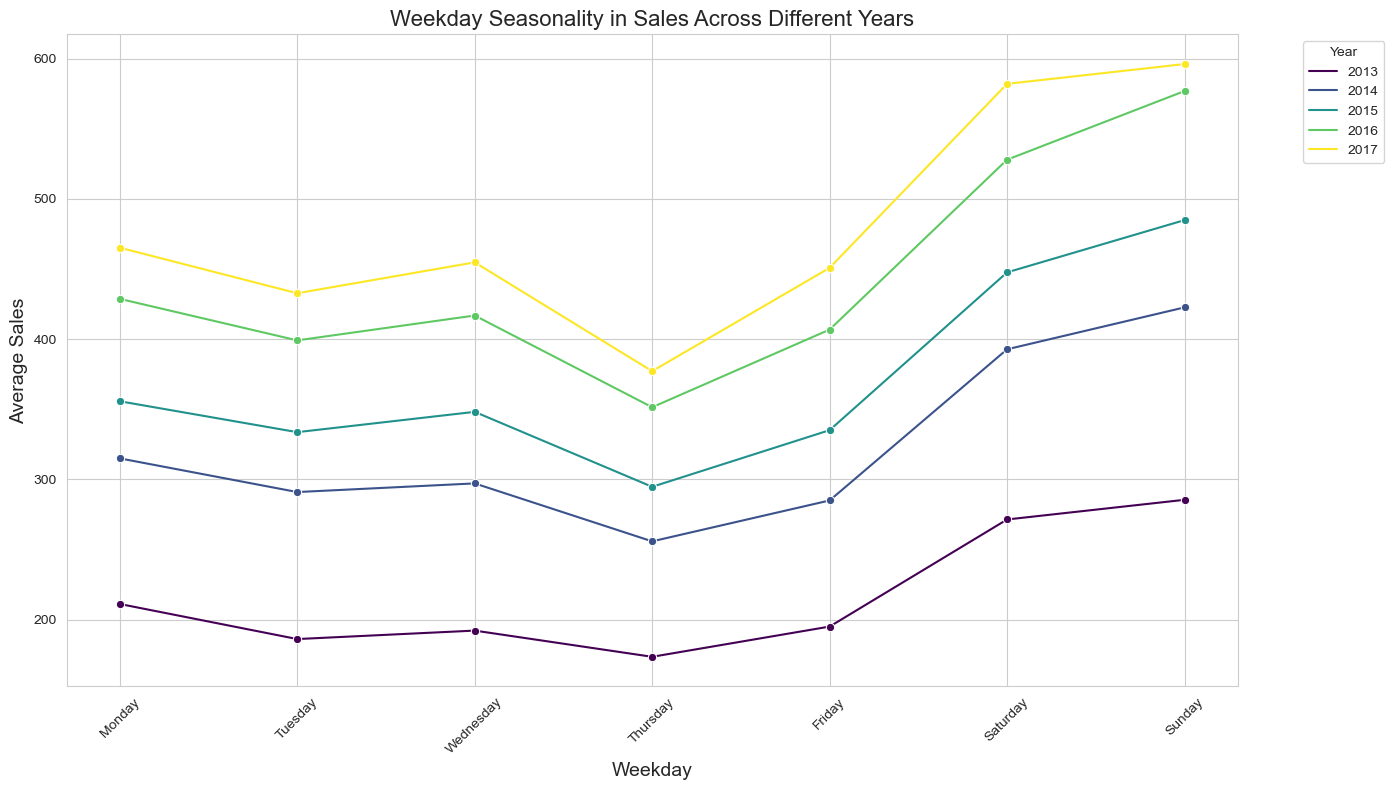

In [43]:
# Ensure 'date' is in datetime format
train_merged['date'] = pd.to_datetime(train_merged['date'])

# Calculate year and weekday
train_merged['year'] = train_merged['date'].dt.year
train_merged['weekday'] = train_merged['date'].dt.day_name()

# Map weekdays to sort them properly later
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
train_merged['weekday'] = pd.Categorical(train_merged['weekday'], categories=weekday_order, ordered=True)

# Aggregate sales by year and weekday
weekday_sales_by_year = train_merged.groupby(['year', 'weekday'])['sales'].mean().reset_index()
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the line plot for weekday sales by year
plt.figure(figsize=(14, 8))
sns.lineplot(data=weekday_sales_by_year, x='weekday', y='sales', hue='year', marker='o', palette='viridis')

# Enhancing the plot
plt.title('Weekday Seasonality in Sales Across Different Years', fontsize=16)
plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.xticks(rotation=45)  # Rotate weekday names for better readability

# Adjust legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot with a tight layout
plt.tight_layout()
plt.show()

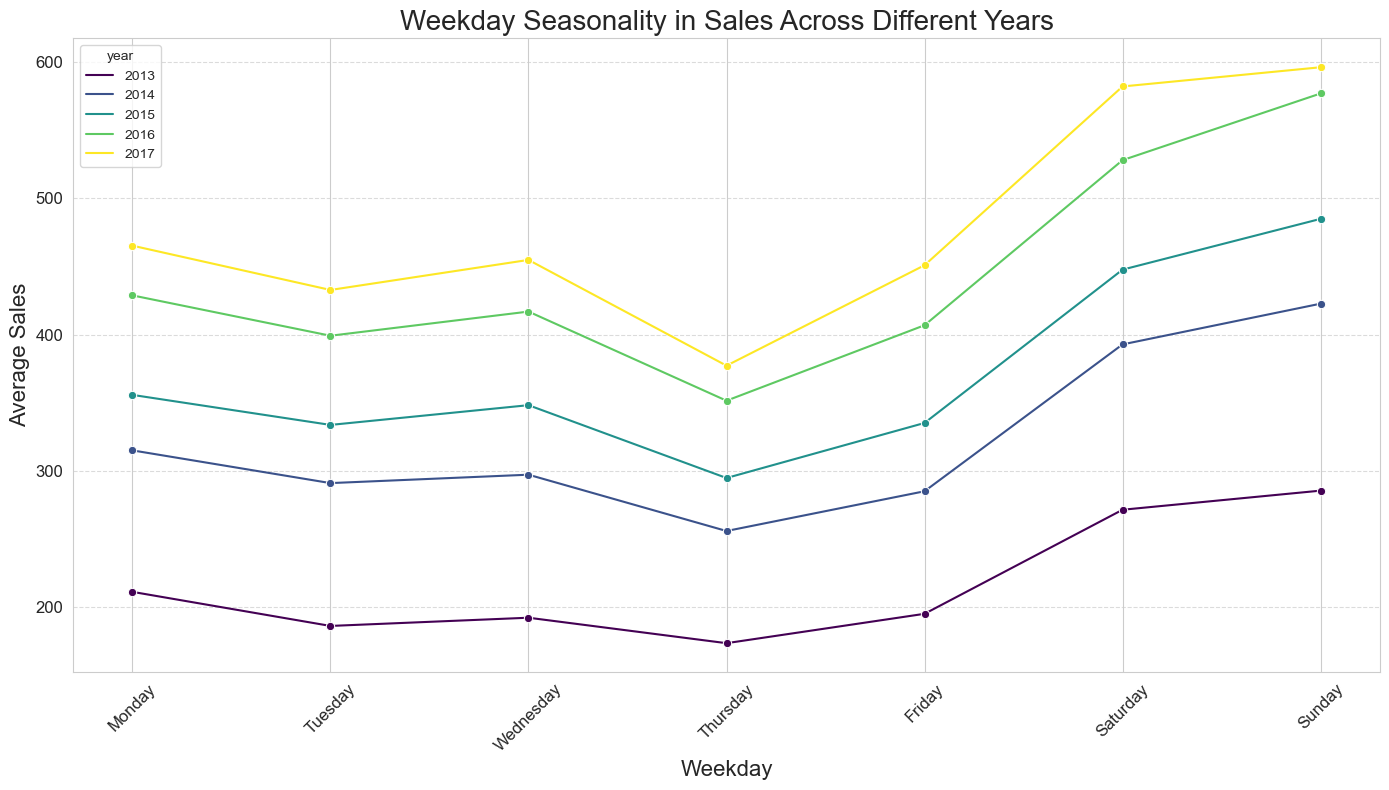

In [44]:
# Ensure 'date' is in datetime format
train_merged['date'] = pd.to_datetime(train_merged['date'])

# Calculate year and weekday
train_merged['year'] = train_merged['date'].dt.year
train_merged['weekday'] = train_merged['date'].dt.day_name()

# Map weekdays to sort them properly later
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
train_merged['weekday'] = pd.Categorical(train_merged['weekday'], categories=weekday_order, ordered=True)

# Aggregate sales by year and weekday
weekday_sales_by_year = train_merged.groupby(['year', 'weekday'])['sales'].mean().reset_index()

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the line plot for weekday sales by year
plt.figure(figsize=(14, 8))
sns.lineplot(data=weekday_sales_by_year, x='weekday', y='sales', hue='year', marker='o', palette='viridis')

# Enhancing the plot
plt.title('Weekday Seasonality in Sales Across Different Years', fontsize=20)
plt.xlabel('Weekday', fontsize=16)
plt.ylabel('Average Sales', fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotate weekday names for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust legend
#plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


In [45]:
train_merged.head()

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,weekend,weekday
0,2013-01-01,1,HOME PRODUCTS,0.0,0,2013,1,1,1,0,Tuesday
1,2013-01-01,1,PERSONAL & BEAUTY,0.0,0,2013,1,1,1,0,Tuesday
2,2013-01-01,1,PERSONAL & BEAUTY,0.0,0,2013,1,1,1,0,Tuesday
3,2013-01-01,1,FOOD & GROCERY,0.0,0,2013,1,1,1,0,Tuesday
4,2013-01-01,1,BOOKS/MAGAZINES,0.0,0,2013,1,1,1,0,Tuesday


In [46]:
# Convert 'date' to datetime if not already done
train_merged['date'] = pd.to_datetime(train_merged['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

# Merge the DataFrames on 'date' and 'store_nbr'
train_merged = pd.merge(train_merged, transactions, on=['date', 'store_nbr'], how='left')
train_merged = pd.merge(train_merged, stores, on='store_nbr', how='left')


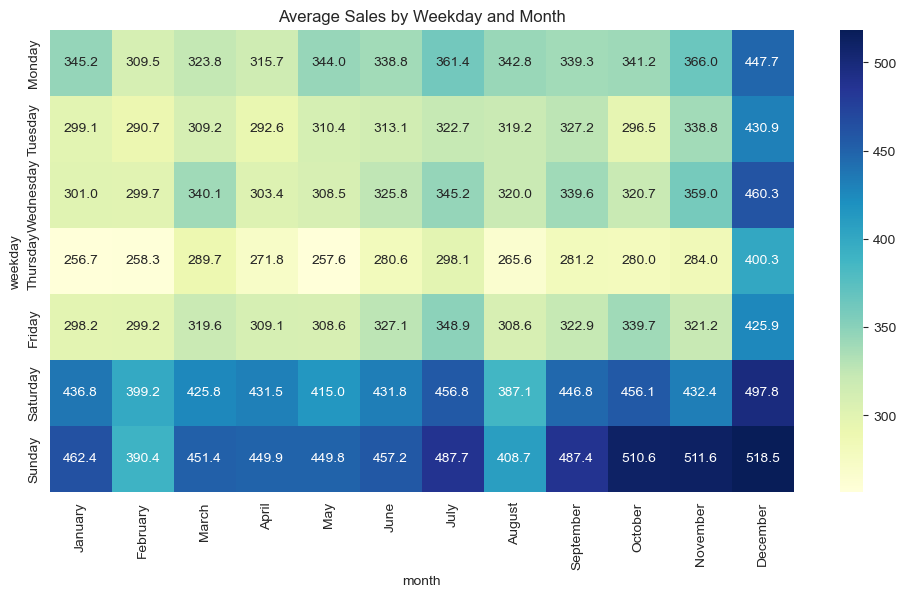

In [48]:
# Ensure 'date' is in datetime format
train_merged['date'] = pd.to_datetime(train_merged['date'])
train_merged['weekday'] = train_merged['date'].dt.day_name()
train_merged['month'] = train_merged['date'].dt.month_name()

# Aggregate sales by weekday and month
sales_pivot = train_merged.pivot_table(index='weekday', columns='month', values='sales', aggfunc='mean')

# Sort the pivot table to have months and weekdays in order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_pivot = sales_pivot.reindex(index=weekday_order, columns=months_order)

# Plotting
plt.figure(figsize=(12, 6))
sns.heatmap(sales_pivot, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Sales by Weekday and Month')
plt.show()

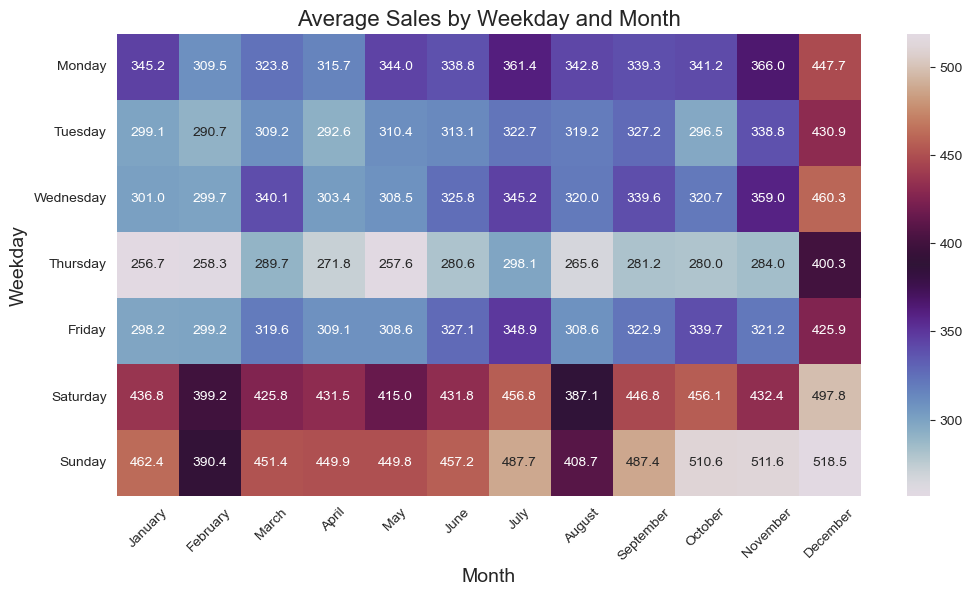

In [49]:
# Ensure 'date' is in datetime format
train_merged['date'] = pd.to_datetime(train_merged['date'])
train_merged['weekday'] = train_merged['date'].dt.day_name()
train_merged['month'] = train_merged['date'].dt.month_name()

# Aggregate sales by weekday and month
sales_pivot = train_merged.pivot_table(index='weekday', columns='month', values='sales', aggfunc='mean')

# Sort the pivot table to have months and weekdays in order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_pivot = sales_pivot.reindex(index=weekday_order, columns=months_order)

# Plotting
plt.figure(figsize=(12, 6))
sns.heatmap(sales_pivot, cmap='twilight', annot=True, fmt=".1f")
plt.title('Average Sales by Weekday and Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Weekday', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [50]:
train_merged.head()

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,weekend,weekday,transactions,city,state,type,cluster
0,2013-01-01,1,HOME PRODUCTS,0.0,0,2013,January,1,1,0,Tuesday,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,PERSONAL & BEAUTY,0.0,0,2013,January,1,1,0,Tuesday,NaN,Quito,Pichincha,D,13
2,2013-01-01,1,PERSONAL & BEAUTY,0.0,0,2013,January,1,1,0,Tuesday,NaN,Quito,Pichincha,D,13
3,2013-01-01,1,FOOD & GROCERY,0.0,0,2013,January,1,1,0,Tuesday,NaN,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS/MAGAZINES,0.0,0,2013,January,1,1,0,Tuesday,NaN,Quito,Pichincha,D,13


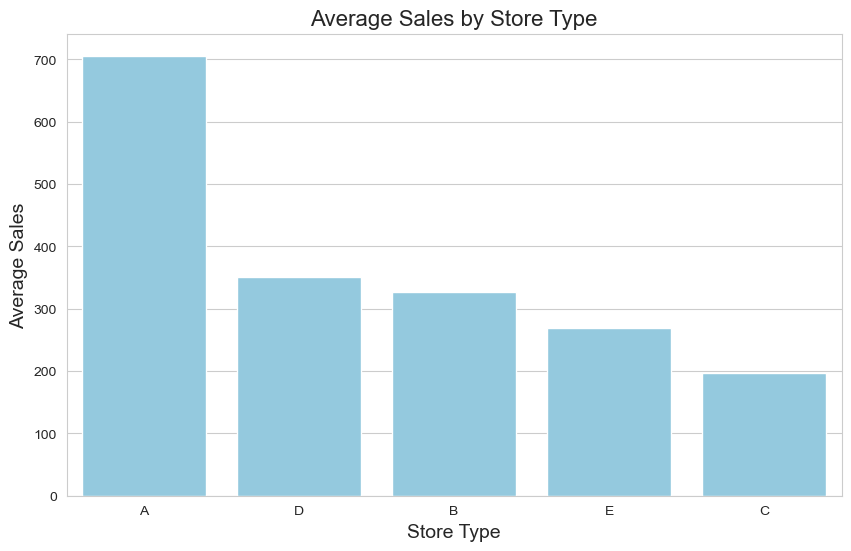

In [51]:
avg_sales_by_type = train_merged.groupby('type')['sales'].mean().reset_index()
avg_sales_by_type_sorted = avg_sales_by_type.sort_values('sales', ascending=False)
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")
# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='type', y='sales', data=avg_sales_by_type_sorted, color='skyblue')

# Enhancing the plot with labels and title
plt.xlabel('Store Type', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.title('Average Sales by Store Type', fontsize=16)
# Show the plot
plt.show()

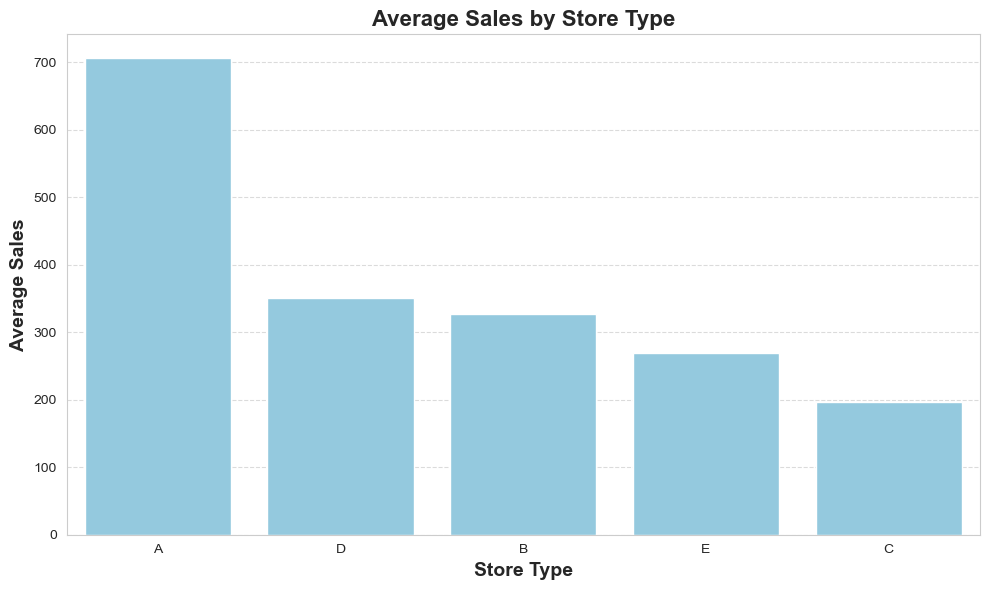

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping and sorting average sales by store type
avg_sales_by_type = train_merged.groupby('type')['sales'].mean().reset_index()
avg_sales_by_type_sorted = avg_sales_by_type.sort_values('sales', ascending=False)

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='type', y='sales', data=avg_sales_by_type_sorted, color='skyblue')

# Enhancing the plot with labels and title
plt.xlabel('Store Type', fontsize=14, fontweight='bold')
plt.ylabel('Average Sales', fontsize=14, fontweight='bold')
plt.title('Average Sales by Store Type', fontsize=16, fontweight='bold')

# Adding horizontal gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


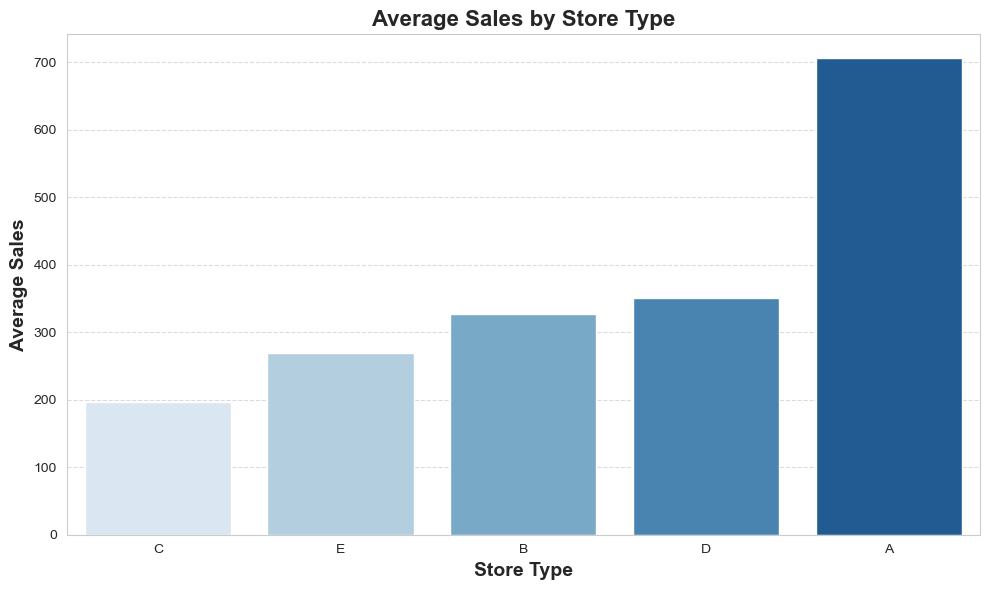

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Grouping and sorting average sales by store type
avg_sales_by_type = train_merged.groupby('type')['sales'].mean().reset_index()
avg_sales_by_type_sorted = avg_sales_by_type.sort_values('sales', ascending=True)

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Define color palette with a gradient
color_palette = sns.color_palette("Blues", len(avg_sales_by_type_sorted))

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='type', y='sales', data=avg_sales_by_type_sorted, palette=color_palette)

# Enhancing the plot with labels and title
plt.xlabel('Store Type', fontsize=14, fontweight='bold')
plt.ylabel('Average Sales', fontsize=14, fontweight='bold')
plt.title('Average Sales by Store Type', fontsize=16, fontweight='bold')

# Adding horizontal gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'sales by month')

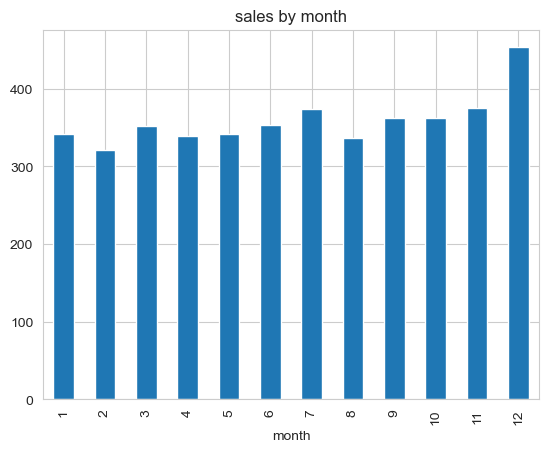

In [54]:
p=df.groupby('month')['sales'].mean()
p.plot(kind='bar')
plt.title('sales by month')

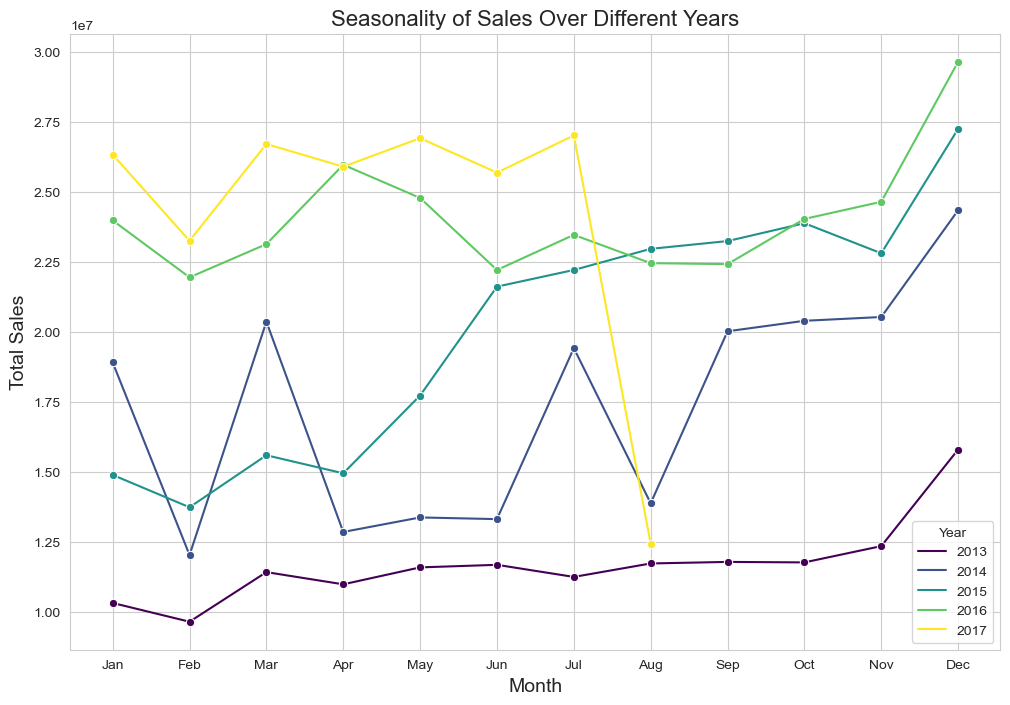

In [55]:
# Ensure 'date' is in datetime format
train_merged['date'] = pd.to_datetime(train_merged['date'])

# Extract year and month from 'date'
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month

# Aggregate sales by year and month
monthly_sales = train_merged.groupby(['year', 'month'])['sales'].sum().reset_index()

# Pivot the data for easy plotting
monthly_sales_pivot = monthly_sales.pivot(index="month", columns="year", values="sales")
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the line plot directly from monthly_sales without pivoting
plt.figure(figsize=(12, 8))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette='viridis', marker='o')

# Adjusting x-axis to show month names
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Enhancing the plot
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.title('Seasonality of Sales Over Different Years', fontsize=16)
plt.legend(title='Year')

# Show the plot
plt.show()

In [56]:
df = train_merged
print("Shape of df:", df.shape)
df.isnull().sum()

Shape of df: (3029400, 16)


date                 0
store_nbr            0
family               0
sales            28512
onpromotion          0
year                 0
month                0
day                  0
day_of_week          0
weekend              0
weekday              0
transactions    274296
city                 0
state                0
type                 0
cluster              0
dtype: int64

In [57]:
df = df.dropna()

In [58]:
print("Shape of df:", df.shape)
df.isnull().sum()

Shape of df: (2755104, 16)


date            0
store_nbr       0
family          0
sales           0
onpromotion     0
year            0
month           0
day             0
day_of_week     0
weekend         0
weekday         0
transactions    0
city            0
state           0
type            0
cluster         0
dtype: int64

In [60]:
lab = LabelEncoder()

In [61]:
train_merged.shape

(3029400, 16)

In [62]:
df.shape

(2755104, 16)

In [63]:
df.family = lab.fit_transform(df.family)

df

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,weekend,weekday,transactions,city,state,type,cluster
561,2013-01-01,25,5,0.000,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1
562,2013-01-01,25,6,0.000,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1
563,2013-01-01,25,6,2.000,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1
564,2013-01-01,25,4,810.000,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1
565,2013-01-01,25,1,0.000,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,4,438.133,0,2017,8,15,1,0,Tuesday,2155.0,Quito,Pichincha,B,6
3000884,2017-08-15,9,4,154.553,1,2017,8,15,1,0,Tuesday,2155.0,Quito,Pichincha,B,6
3000885,2017-08-15,9,4,2419.729,148,2017,8,15,1,0,Tuesday,2155.0,Quito,Pichincha,B,6
3000886,2017-08-15,9,9,121.000,8,2017,8,15,1,0,Tuesday,2155.0,Quito,Pichincha,B,6


In [64]:
# Merge df with stores table on 'store_nbr' column
df1 = pd.merge(df, stores[['store_nbr', 'city']], how='left', left_on='store_nbr', right_on='store_nbr')

# Drop the redundant 'store_nbr' column from the stores DataFrame
df1.drop(columns=['city_y'], inplace=True)
df1.rename(columns={'city_x': 'city'}, inplace=True)

# Display the modified DataFrame
print(df1.tail())
df1.shape

              date  store_nbr  family     sales  onpromotion  year  month  \
2755099 2017-08-15          9       4   438.133            0  2017      8   
2755100 2017-08-15          9       4   154.553            1  2017      8   
2755101 2017-08-15          9       4  2419.729          148  2017      8   
2755102 2017-08-15          9       9   121.000            8  2017      8   
2755103 2017-08-15          9       4    16.000            0  2017      8   

         day  day_of_week  weekend  weekday  transactions   city      state  \
2755099   15            1        0  Tuesday        2155.0  Quito  Pichincha   
2755100   15            1        0  Tuesday        2155.0  Quito  Pichincha   
2755101   15            1        0  Tuesday        2155.0  Quito  Pichincha   
2755102   15            1        0  Tuesday        2155.0  Quito  Pichincha   
2755103   15            1        0  Tuesday        2155.0  Quito  Pichincha   

        type  cluster  
2755099    B        6  
2755100    B  

(2755104, 16)

In [65]:
# Iterate over each row in the 'holidays' DataFrame
for index, row in holidays.iterrows():
    date = row['date']
    locale = row['locale']
    locale_name = row['locale_name']
    
    # Check the 'locale' value and set 'IsHoliday' accordingly
    if locale == 'Local':
        df1.loc[(df1['date'] == date) & (df1['city'] == locale_name), 'IsHoliday'] = 1
    elif locale == 'Regional':
        df1.loc[(df1['date'] == date) & (df1['state'] == locale_name), 'IsHoliday'] = 1
    elif locale == 'National':
        df1.loc[df1['date'] == date, 'IsHoliday'] = 1

# Fill the remaining values in 'IsHoliday' column with 0
df1['IsHoliday'].fillna(0, inplace=True)



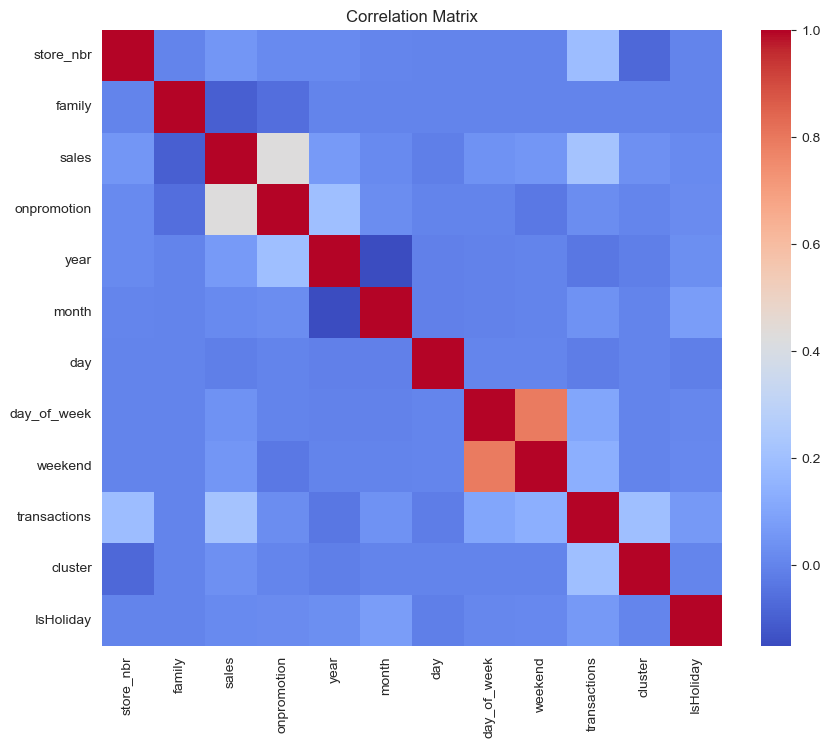

In [66]:
# Assuming 'data' is your DataFrame containing your data
# Select only numeric columns
df = df1
numeric_data = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Visualize the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [67]:
cor_sorted = correlation_matrix['sales'].sort_values(ascending=False)

# Select only high correlations (absolute correlation > 0.2)
CorHigh = cor_sorted[abs(cor_sorted) > 0]

# Display feature names along with their correlation values
for feature, correlation in CorHigh.items():
    print(f"{feature}: {correlation:.2f}")

sales: 1.00
onpromotion: 0.43
transactions: 0.21
year: 0.07
store_nbr: 0.06
weekend: 0.05
day_of_week: 0.04
cluster: 0.04
IsHoliday: 0.02
month: 0.02
day: -0.01
family: -0.10


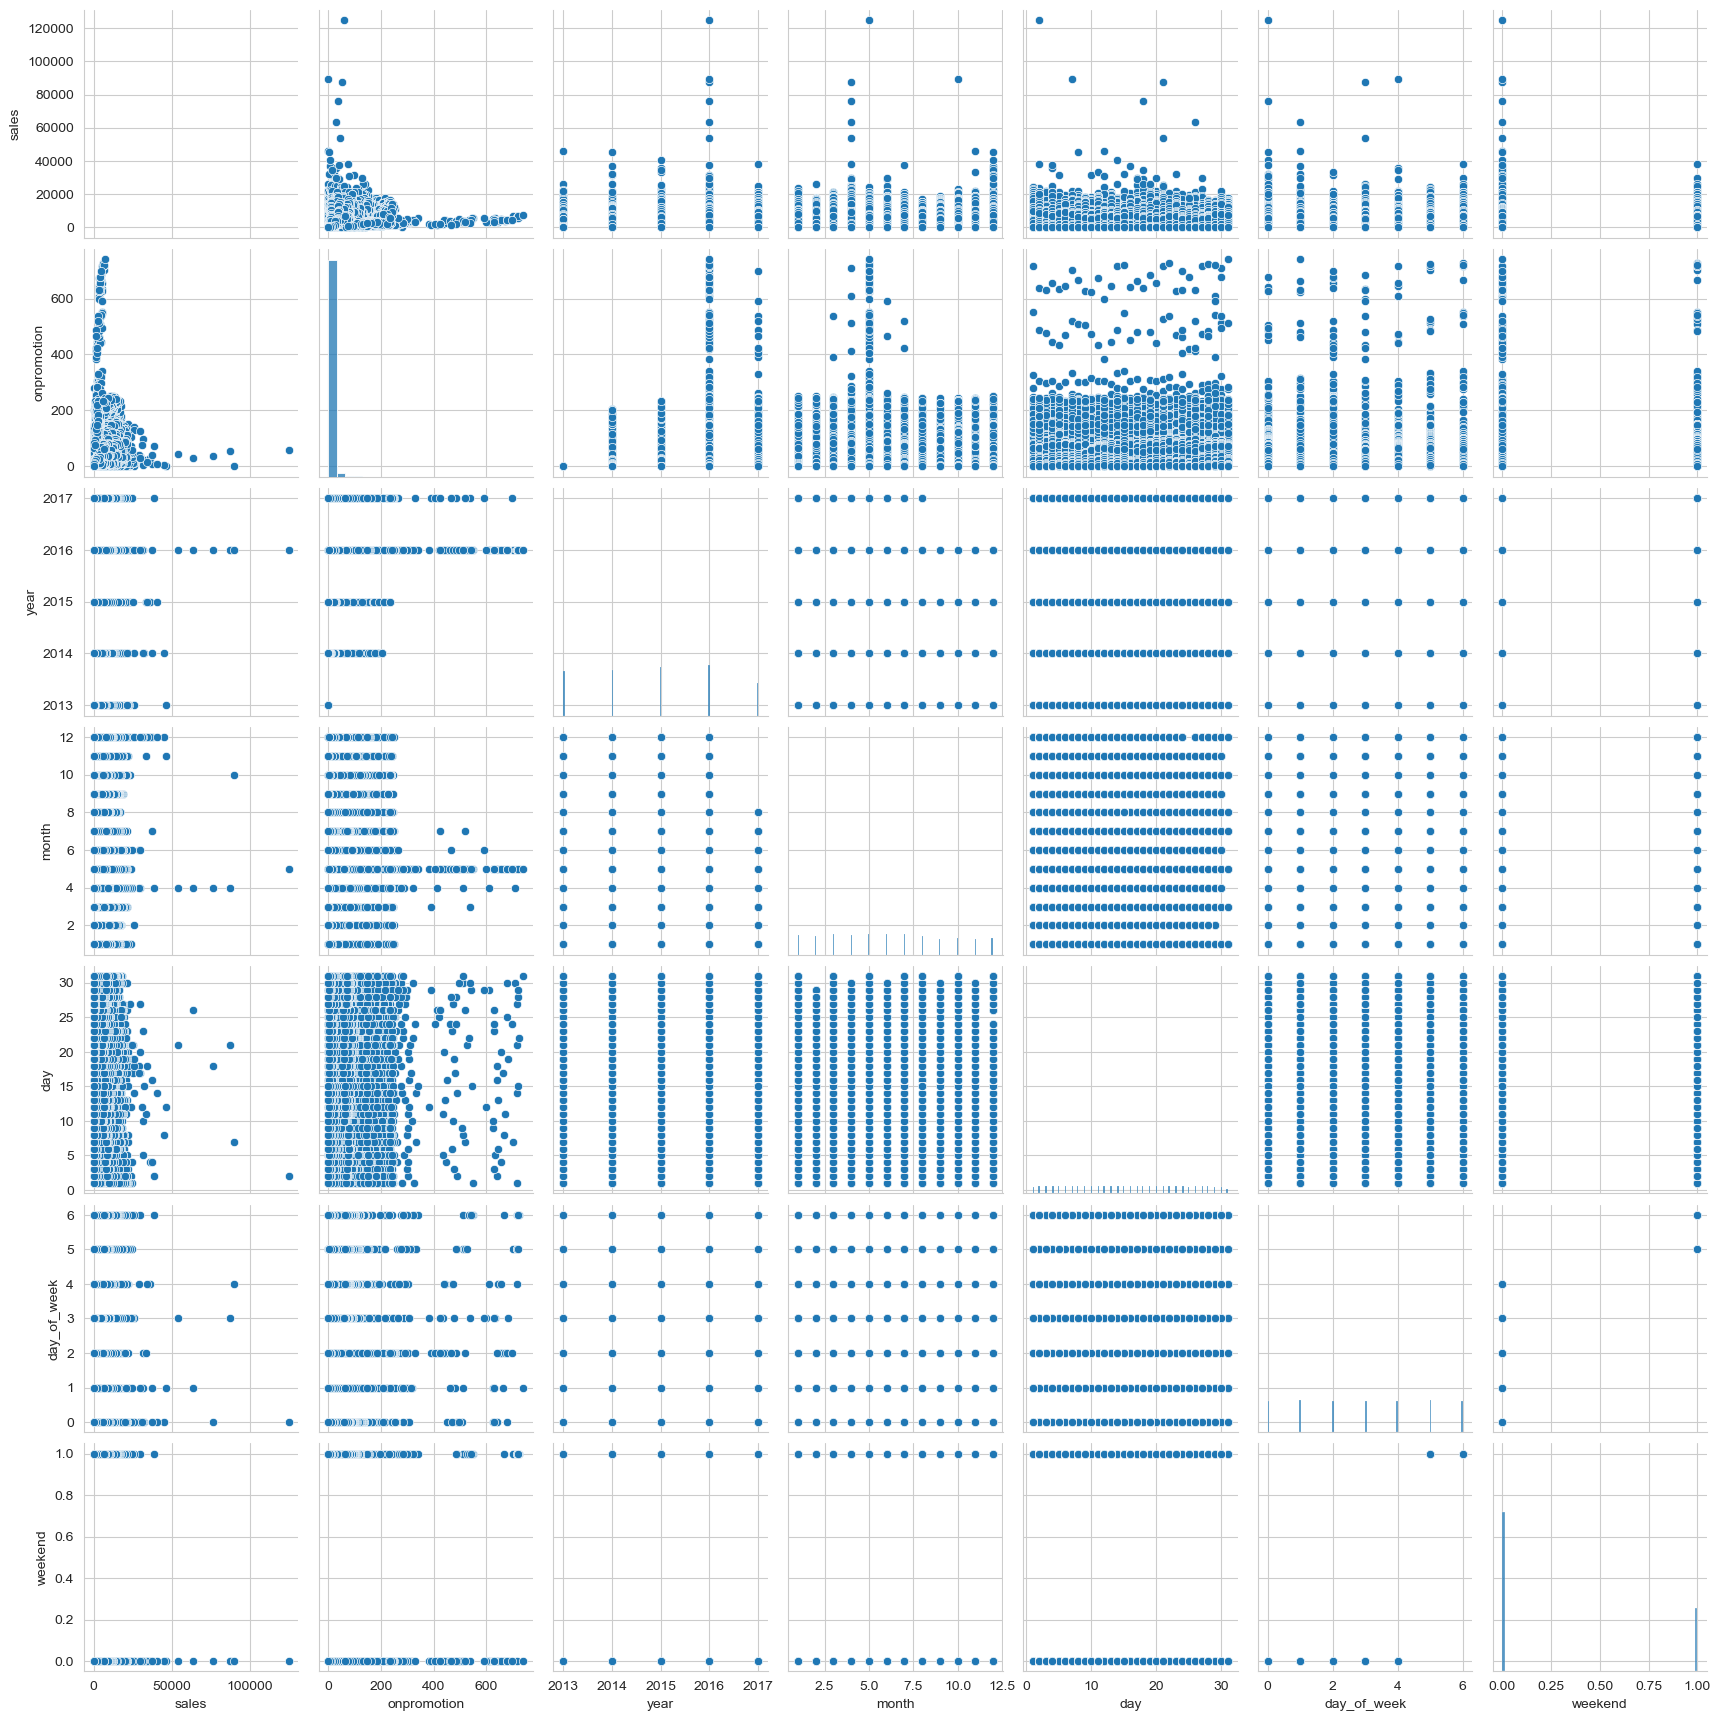

In [68]:
sns.pairplot(df.iloc[:,3:10])

In [69]:
dfDummy = df

#Family - Sales
dfDummy = dfDummy.drop(dfDummy[(dfDummy['family']==4) & (dfDummy['sales'] > 120000)].index)


#onpromotion - Sales
dfDummy = dfDummy.drop(dfDummy[(dfDummy['onpromotion']<200) & (dfDummy['sales'] > 50000)].index)

#year - Sales
dfDummy = dfDummy.drop(dfDummy[(dfDummy['year'] == 2016) & (dfDummy['sales'] > 50000)].index)

In [ ]:
sns.pairplot(dfDummy.iloc[:,3:10])

In [ ]:

# Plot the distribution plot
sns.distplot(df['sales'], fit=stats.norm, ax=axes[0])
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of SalePrice')


sns.distplot(np.log1p(df_train["sales"]), fit=stats.norm, ax=axes[1])
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of SalePrice after log transformation')

# Adjust layout
plt.tight_layout()

plt.show()

In [70]:
from sklearn.metrics import mean_squared_error

In [71]:
df=dfDummy
df.head()

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,weekend,weekday,transactions,city,state,type,cluster,IsHoliday
0,2013-01-01,25,5,0.0,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1,1.0
1,2013-01-01,25,6,0.0,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1,1.0
2,2013-01-01,25,6,2.0,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1,1.0
3,2013-01-01,25,4,810.0,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1,1.0
4,2013-01-01,25,1,0.0,0,2013,1,1,1,0,Tuesday,770.0,Salinas,Santa Elena,D,1,1.0


In [72]:
import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import joblib

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale

rand_st=1

In [ ]:
#Decision Tree

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer, scale

In [ ]:
print("Shape of df:", df.shape)

In [ ]:
lab = LabelEncoder()
df.city = lab.fit_transform(df.city)
df.state = lab.fit_transform(df.state)
df.weekday = lab.fit_transform(df.weekday)
df.type = lab.fit_transform(df.type)

X = df.drop(['sales','store_nbr','date'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)
#X.head()

In [ ]:
print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)


#SciKit Decision Tree Regressor
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=1)
rgr.fit(data_train, target_train)

scores_RMSE = math.sqrt(metrics.mean_squared_error(target_test, rgr.predict(data_test)))
print('Decision Tree RMSE:', scores_RMSE)
scores_Expl_Var = metrics.explained_variance_score(target_test, rgr.predict(data_test))
print('Decision Tree Expl Var:', scores_Expl_Var)
#print("CV Runtime:", time.time()-start_ts)

####Cross-Val Regressors####
    #Setup Crossval regression scorers
scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'}

#SciKit Decision Tree Regressor - Cross Val
#start_ts=time.time()
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=1)
scores = cross_validate(rgr, X, y, scoring=scorers, cv=10)

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Decision Tree RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Decision Tree Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
#print("CV Runtime:", time.time()-start_ts)

In [ ]:
print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)


#SciKit Decision Tree Regressor
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
rgr.fit(data_train, target_train)

scores_RMSE = math.sqrt(metrics.mean_squared_error(target_test, rgr.predict(data_test)))
print('Decision Tree RMSE:', scores_RMSE)
scores_Expl_Var = metrics.explained_variance_score(target_test, rgr.predict(data_test))
print('Decision Tree Expl Var:', scores_Expl_Var)

####Cross-Val Regressors####
    #Setup Crossval regression scorers
scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'}

#SciKit Decision Tree Regressor - Cross Val
start_ts=time.time()
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
scores = cross_validate(rgr, X, y, scoring=scorers, cv=5)

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Decision Tree RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Decision Tree Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))


In [ ]:
print('--ML Model Output--', '\n')

# Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35, random_state=rand_st)

# SciKit Decision Tree Regressor
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
rgr.fit(data_train, target_train)

# Feature Importance
feature_importance = rgr.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
print("Feature ranking:")
for i, idx in enumerate(sorted_idx):
    print(f"{i+1}. Feature {idx}: {feature_importance[idx]}")

scores_RMSE = math.sqrt(metrics.mean_squared_error(target_test, rgr.predict(data_test)))
print('Decision Tree RMSE:', scores_RMSE)
scores_Expl_Var = metrics.explained_variance_score(target_test, rgr.predict(data_test))
print('Decision Tree Expl Var:', scores_Expl_Var)

#### Cross-Val Regressors####
# Setup Crossval regression scorers
scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'}

# SciKit Decision Tree Regressor - Cross Val
start_ts = time.time()
scores = cross_validate(rgr, X, y, scoring=scorers, cv=10)

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])  # Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Decision Tree RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Decision Tree Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))



In [90]:
X = df.drop(['sales','store_nbr','date'],axis=1)
print(X.head())
y = df['sales']
X=scale(X)
y=scale(y)

   family  onpromotion  year  month  day  day_of_week  weekend  weekday  \
0       5            0  2013      1    1            1        0        5   
1       6            0  2013      1    1            1        0        5   
2       6            0  2013      1    1            1        0        5   
3       4            0  2013      1    1            1        0        5   
4       1            0  2013      1    1            1        0        5   

   transactions  city  state  type  cluster  IsHoliday  
0         770.0    20     13     3        1        1.0  
1         770.0    20     13     3        1        1.0  
2         770.0    20     13     3        1        1.0  
3         770.0    20     13     3        1        1.0  
4         770.0    20     13     3        1        1.0  


In [91]:
#Test Wrapper
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=1)
sel = SelectFromModel(rgr, prefit=False, threshold=0.07 , max_features=None)                   
print ('Wrapper Select: ')

fit_mod=sel.fit(X, y)    
sel_idx=fit_mod.get_support()
print("sel_idx",sel_idx)

temp=[]
temp_idx=[]
temp_del=[]
for i in range(len(X[0])):
    if sel_idx[i]==1:                                                           #Selected Features get added to temp header
        #temp.append(header[i])
        temp_idx.append(i)
    else:                                                                       #Indexes of non-selected features get added to delete array
        temp_del.append(i)
print('Selected:', temp)
print('Features (total/selected):', len(X[0]), len(temp))
print('\n')

data_np = np.delete(X, temp_del, axis=1)                                 #Deletes non-selected features by index)
print("data_np",data_np)
X = data_np
# Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35, random_state=rand_st)

# SciKit Decision Tree Regressor
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
rgr.fit(data_train, target_train)

# Feature Importance
feature_importance = rgr.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
print("Selected Features and their Importance:")
for i, idx in enumerate(sorted_idx):
    print(f"{i+1}. Feature {idx}: {feature_importance[idx]}")

selected_features = [f"Feature {idx}" for idx in sorted_idx]  # Get names of selected features

scores_RMSE = math.sqrt(metrics.mean_squared_error(target_test, rgr.predict(data_test)))
print('Decision Tree RMSE:', scores_RMSE)
scores_Expl_Var = metrics.explained_variance_score(target_test, rgr.predict(data_test))
print('Decision Tree Expl Var:', scores_Expl_Var)

#### Cross-Val Regressors####
# Setup Crossval regression scorers
scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'}

# SciKit Decision Tree Regressor - Cross Val
start_ts = time.time()
scores = cross_validate(rgr, X, y, scoring=scorers, cv=10)

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])  # Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Decision Tree RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Decision Tree Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))


Wrapper Select: 
sel_idx [ True  True False False False False False False  True False False False
 False False]
Selected: []
Features (total/selected): 14 0


data_np [[ 0.28444078 -0.22263168 -0.95984585]
 [ 0.83659167 -0.22263168 -0.95984585]
 [ 0.83659167 -0.22263168 -0.95984585]
 ...
 [-0.2677101  11.40813416  0.4779491 ]
 [ 2.49304434  0.40605837  0.4779491 ]
 [-0.2677101  -0.22263168  0.4779491 ]]
Selected Features and their Importance:
1. Feature 2: 0.44105100604187597
2. Feature 1: 0.4074859362459209
3. Feature 0: 0.15146305771220325
Decision Tree RMSE: 0.8855880412557185
Decision Tree Expl Var: 0.21654656205203393
Decision Tree RMSE:: 0.88 (+/- 0.33)
Decision Tree Expl Var: 0.19 (+/- 0.09)


In [ ]:
onpromotion: 0.574446142015317
family: 0.1297149792164202
day: 0.08827403728437165

In [ ]:
## RandomForest

In [ ]:
X = df.drop(['sales','store_nbr','date','id'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)

In [ ]:
print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)


#SciKit Random Forest Regressor - Cross Val
#start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=0.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=1)    
scores = cross_validate(rgr, X, y, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Random Forest RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
#print("CV Runtime:", time.time()-start_ts)

In [ ]:
X = df.drop(['sales','store_nbr','date'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)

In [ ]:
# SciKit Random Forest Regressor - Cross Val
start_ts = time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=0.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)

# Fit the model to the training data
rgr.fit(data_train, target_train)

# Access feature importances after fitting
feature_importance = rgr.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
print("Selected Features and their Importance:")
for i, idx in enumerate(sorted_idx):
    print(f"{i+1}. Feature {idx}: {feature_importance[idx]}")

# Perform cross-validation
scores = cross_validate(rgr, X, y, scoring=scorers, cv=5)

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])  # Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % (scores_RMSE.mean(), scores_RMSE.std() * 2))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % (scores_Expl_Var.mean(), scores_Expl_Var.std() * 2))
print("CV Runtime:", time.time() - start_ts)


In [ ]:
X = df.drop(['sales','store_nbr','date'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import math
import time

# Assuming X, y are your features and target variable respectively
# Assuming rand_st is defined as your random state

# Define your RandomForestRegressor model
rgr = RandomForestRegressor(n_estimators=100, max_features=0.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)

# Create SelectFromModel object with a specific threshold value
threshold_value = 0.1  # Set your desired threshold value
sel = SelectFromModel(rgr, prefit=False, threshold=threshold_value, max_features=None)

# Fit SelectFromModel to your data
fit_mod = sel.fit(X, y)
sel_idx = fit_mod.get_support()

print("Selected feature indices:", sel_idx)

temp_idx = [i for i, selected in enumerate(sel_idx) if selected == 1]
temp_del = [i for i, selected in enumerate(sel_idx) if selected == 0]

print('Selected feature indices:', temp_idx)
print('Features (total/selected):', len(X[0]), len(temp_idx))

# Filter selected columns from the original dataset
data_np = np.delete(X, temp_del, axis=1)
X = data_np

# Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35, random_state=rand_st)

# SciKit Random Forest Regressor - Cross Val
start_ts = time.time()
rgr.fit(data_train, target_train)  # Fit the model to the training data

# Access feature importances after fitting
feature_importance = rgr.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
print("Selected Features and their Importance:")
for i, idx in enumerate(sorted_idx):
    print(f"{i+1}. Feature {idx}: {feature_importance[idx]}")

# Perform cross-validation
scores = cross_validate(rgr, X, y, scoring=scorers, cv=5)

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])  # Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % (scores_RMSE.mean(), scores_RMSE.std() * 2))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % (scores_Expl_Var.mean(), scores_Expl_Var.std() * 2))
print("CV Runtime:", time.time() - start_ts)


In [ ]:
X = df.drop(['sales','store_nbr','date'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)

In [ ]:
#Normalized

print('--ML Model Output--', '\n')
X=scale(X) 

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)


#SciKit Random Forest Regressor - Cross Val
#start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=0.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=1)    
scores = cross_validate(rgr, X, y, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Random Forest RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
#print("CV Runtime:", time.time()-start_ts)

In [ ]:
X = df.drop(['sales','store_nbr','date'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor 

print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)


#SciKit Bagging Regressor - Cross Val
start_ts=time.time()
rgr = DecisionTreeRegressor(criterion='friedman_mse', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)

bag = BaggingRegressor(max_samples=0.6, random_state=rand_st)
bag.fit(data_train, target_train)

scores_RMSE = math.sqrt(metrics.mean_squared_error(target_test, bag.predict(data_test)))
print('Bagging RMSE:', scores_RMSE)
scores_Expl_Var = metrics.explained_variance_score(target_test, bag.predict(data_test))
print('Bagging Expl Var:' , scores_Expl_Var)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor


In [ ]:
## Gradient Boost

In [ ]:
X = df.drop(['sales','store_nbr','date'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)

In [ ]:
  #SciKit Gradient Boosting - Cross Val
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)

start_ts=time.time()
rgr=GradientBoostingRegressor(n_estimators=100, loss='ls', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st).fit(data_train, target_train)
scores=cross_validate(rgr, X, y, scoring=scorers, cv=5)                                                                                                  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Gradient Boosting RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Gradient Boosting Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts, '\n')


 

In [ ]:
## ADA Boost

In [ ]:
X = df.drop(['sales','store_nbr','date'],axis=1)
y = df['sales']
X=scale(X)
y=scale(y)

In [ ]:
#SciKit Ada Boosting - Cross Val
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)

start_ts=time.time()
rgr=AdaBoostRegressor(n_estimators=100, base_estimator=None ,loss='linear', learning_rate=0.5, random_state=rand_st).fit(data_train, target_train)
scores=cross_validate(rgr, X, y, scoring=scorers, cv=5)                                                                                                   

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Ada Boosting RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Ada Boosting Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

In [73]:
## SVM
lab = LabelEncoder()
df.city = lab.fit_transform(df.city)
df.weekday = lab.fit_transform(df.weekday)
df.state = lab.fit_transform(df.state)
df.type = lab.fit_transform(df.type)

df

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,weekend,weekday,transactions,city,state,type,cluster,IsHoliday
0,2013-01-01,25,5,0.000,0,2013,1,1,1,0,5,770.0,20,13,3,1,1.0
1,2013-01-01,25,6,0.000,0,2013,1,1,1,0,5,770.0,20,13,3,1,1.0
2,2013-01-01,25,6,2.000,0,2013,1,1,1,0,5,770.0,20,13,3,1,1.0
3,2013-01-01,25,4,810.000,0,2013,1,1,1,0,5,770.0,20,13,3,1,1.0
4,2013-01-01,25,1,0.000,0,2013,1,1,1,0,5,770.0,20,13,3,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755099,2017-08-15,9,4,438.133,0,2017,8,15,1,0,5,2155.0,18,12,1,6,0.0
2755100,2017-08-15,9,4,154.553,1,2017,8,15,1,0,5,2155.0,18,12,1,6,0.0
2755101,2017-08-15,9,4,2419.729,148,2017,8,15,1,0,5,2155.0,18,12,1,6,0.0
2755102,2017-08-15,9,9,121.000,8,2017,8,15,1,0,5,2155.0,18,12,1,6,0.0


In [74]:
from sklearn.svm import SVR

In [83]:
X = df.drop(['sales','store_nbr','date'],axis=1)
X=X[0:30000]
y = df['sales'][0:30000]
X=scale(X)
y=scale(y)

In [84]:
#rbf

data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

#SciKit SVM - Cross Val
start_ts=time.time()
rgr= SVR(kernel='rbf', gamma=0.1, C=1.0)
scores=cross_validate(rgr, X, y, scoring=scorers, cv=5)                                                                                               

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("SVM RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("SVM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

SVM RMSE:: 0.98 (+/- 0.26)
SVM Expl Var: 0.07 (+/- 0.02)
CV Runtime: 151.98181200027466


In [85]:
#linear
X = df.drop(['sales','store_nbr','date'],axis=1)
X=X[0:30000]
y = df['sales'][0:30000]
X=scale(X)
y=scale(y)

In [86]:

data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

#SciKit SVM - Cross Val
start_ts=time.time()
rgr= SVR(kernel='linear', gamma=0.1, C=1.0)
scores=cross_validate(rgr, X, y, scoring=scorers, cv=5)                                                                                               

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("SVM RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("SVM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

SVM RMSE:: 1.02 (+/- 0.26)
SVM Expl Var: 0.00 (+/- 0.00)
CV Runtime: 411.9507429599762


In [87]:
#sigmoid
X = df.drop(['sales','store_nbr','date'],axis=1)
X=X[0:30000]
y = df['sales'][0:30000]
X=scale(X)
y=scale(y)

In [88]:

data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

#SciKit SVM - Cross Val
start_ts=time.time()
rgr= SVR(kernel='sigmoid', gamma=0.1, C=1.0)
scores=cross_validate(rgr, X, y, scoring=scorers, cv=5)                                                                                               

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("SVM RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("SVM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

SVM RMSE:: 143.52 (+/- 75.83)
SVM Expl Var: -21216.64 (+/- 20284.74)
CV Runtime: 241.44056582450867
